# Assignment 1 : Data Curation

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2020. All analysis should be performed in a single Jupyter notebook and all data, documentation, and code should be published in a single GitHub repository.


# Required Packages

- numpy : (https://numpy.org/)
- pandas : (https://pandas.pydata.org/)
- matplotlib : (https://matplotlib.org/)
- requests : (https://requests.readthedocs.io/en/master/)

# Data Source

- The Legacy Pagecounts API (documentation (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) , endpoint (https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end) ) provides access to desktop and mobile traffic data from December 2007 through July 2016.

- The Pageviews API (documentation (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), endpoint (https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

Terms of use: https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions

Import all the libraries

In [45]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The following code is being reused. Original code can be found here (https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb)

The following cell declares the endpoints and the parameters to create the API request

In [46]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : "2020080100"
                        }

headers = {
    'User-Agent': 'https://github.com/medha-sagar',
    'From': 'sagarme@uw.edu'
}

Function "api_call" requests the data from the Wikimedia Page

In [47]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

Define the JSON File Names that we want to create using different endpoints and channels

In [48]:
file_names = ["pagecounts_desktop-site_200801-202008.json", 
         "pagecounts_mobile-site_200801-202008.json",
              "pageviews_desktop_200801-202008.json", 
         "pageviews_mobile-app_200801-202008.json",
         "pageviews_mobile-web_200801-202008.json"]

The following code gets all the data from the endpoints, creates the JSON and the dataframes. It also removes the excess columns and renames the data to maintain a uniform structure

In [49]:
for file_name in file_names:
    page = file_name.split("_")[0]
    channel = file_name.split("_")[1]
    
    if page == 'pagecounts':
        params_legacy["access-site"] = channel
        data = api_call(endpoint_legacy, params_legacy)
        df = pd.DataFrame.from_dict(data['items'])
        df = df.rename(columns={"access-site": "access", "count": "pagecount_{}_views".format(channel.replace("-site",""))})
        
    if page == 'pageviews':
        params_pageviews["access"] = channel
        data = api_call(endpoint_pageviews, params_pageviews)
        df = pd.DataFrame.from_dict(data['items'])
        df = df.drop(["agent"], axis = 1)
        df = df.rename(columns={ "views": "pageview_{}_views".format(channel.replace("-site",""))})
    
    with open(file_name, 'w') as f:
        json.dump(data, f)
    
    df['timestamp'] = pd.to_datetime(df.timestamp, format="%Y%m%d%H")
    df['year'] = pd.DatetimeIndex(df['timestamp']).year
    df['month'] = pd.DatetimeIndex(df['timestamp']).month
    df = df.drop(["timestamp", "project", "granularity"], axis = 1)
    
    df.to_csv(file_name.replace(".json", ".csv"),index = False)

Combine the results from Mobile web and Mobile app

In [50]:
mobile_web_data = pd.read_csv("pageviews_mobile-web_200801-202008.csv")
mobile_app_data = pd.read_csv("pageviews_mobile-app_200801-202008.csv")
pageviews_mobile_data = mobile_web_data

pageviews_mobile_data["pageview_mobile_views"] = pageviews_mobile_data["pageview_mobile-web_views"] + mobile_app_data["pageview_mobile-app_views"]
pageviews_mobile_data.to_csv("pageview_mobile_200801-202008.csv", index = False)



Merge all the datasets together to create a master dataset

In [51]:
df = pageviews_mobile_data
df = df.drop(["access", "pageview_mobile-web_views"], axis=1)
file_names = [ "pageviews_desktop_200801-202008.csv", "pagecounts_desktop-site_200801-202008.csv", "pagecounts_mobile-site_200801-202008.csv"]

for file_name in file_names:
    other = pd.read_csv(file_name)
    other = other.drop(["access"], axis = 1)
    df = pd.merge(df, other, on=["month", "year"], how="outer")

df = df.fillna(0)   
df["pagecount_all_views"] = df["pagecount_desktop_views"] + df["pagecount_mobile_views"]
df["pageview_all_views"] = df["pageview_desktop_views"] + df["pageview_mobile_views"]

df.to_csv("en-wikipedia_traffic_200712-202008.csv", index = False)

Make year and month as index and sort the result

In [52]:
df = df.set_index(['year', 'month'])
df.sort_index(inplace=True)

# Plot the results

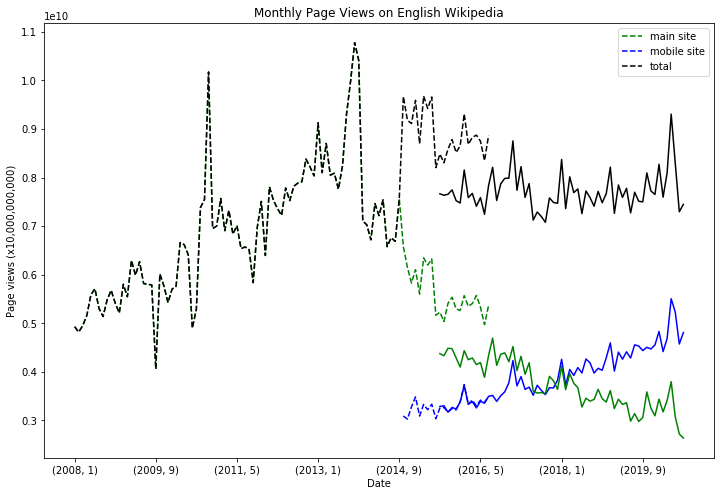

In [53]:
df = df.replace({0:np.nan})
df.plot(xlabel="Date", ylabel="Page views (x10,000,000,000)", kind='line', figsize=(12,8), title="Monthly Page Views on English Wikipedia", style = ['-','-','--','--','--','-'], color=['blue','green','green','blue','black','black']) 

fig = plt.gcf()
plt.legend(['_Hidden', '_Hidden', 'main site', 'mobile site', 'total', '_Hidden'])
plt.show()


# Saving the PGN

In [54]:
fig.savefig('EN_WIKI_VIEWS.png', dpi=300,quality=95)